# 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
---

## 프로젝트 1-1

1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(552, 740)


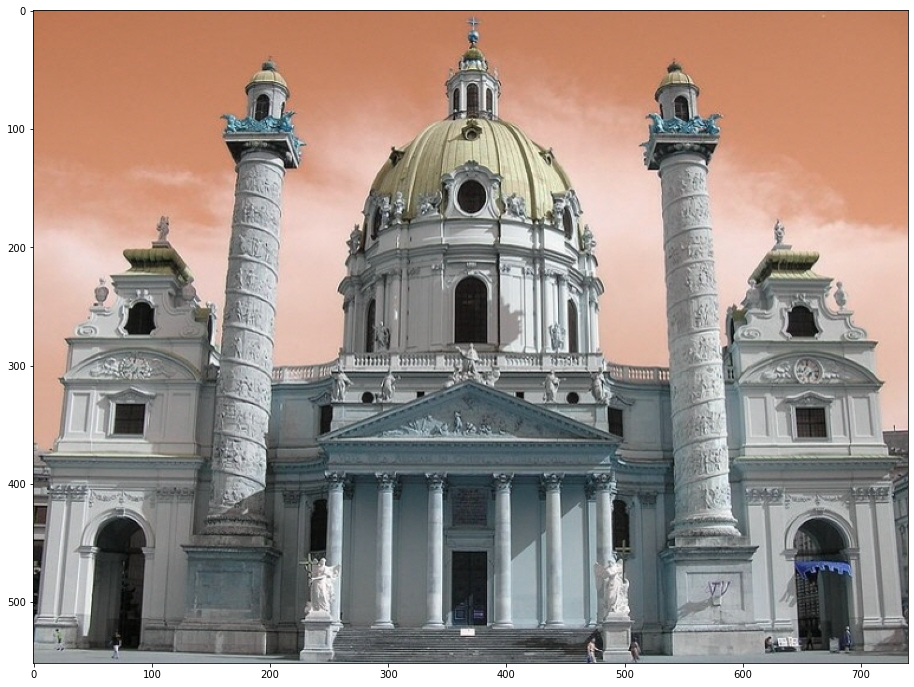

In [2]:
import cv2
import matplotlib.pyplot as plt

hr_img = cv2.imread('/content/drive/MyDrive/EX/EX16/baroque.jpg') # skimage에서 제공하는 예제 이미지를 불러온다.
#hr_img = cv2.resize(hr_img, dsize=(hr_img.shape[1], hr_img.shape[0]+1))
hr_shape = hr_img.shape[:2]

print(hr_shape) # 이미지의 크기를 출력한다.

plt.figure(figsize=(20,12))
plt.imshow(hr_img)

이미지의 특정 부위를 확인하기 위해 crop 함수를 정의한다. 매개변수 left_top은 좌상단 좌표를 의미하고 x, y는 각각 이미지의 width, height를 의미한다.

In [3]:
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

이미지를 1/n로 줄이고 Bicubic interpolation 으로 n배하는 interpolation_xn 함수를 정의한다

In [4]:
def interpolation_xn(image, n):
    downsample = cv2.resize(
        image,
        dsize=(hr_shape[1]//n, hr_shape[0]//n)
    )
    upsample = cv2.resize(
        downsample,
        dsize=(hr_shape[1], hr_shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
    return upsample

bicubic_img = interpolation_xn(hr_img, 4)
bicubic_img.shape[:2]

(552, 740)

기존 노드에서 사용한 미리 학습된 srgan_G 모델을 불러온다

In [5]:
import tensorflow as tf
import os

model_file = '/content/drive/MyDrive/EX/EX16/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

(552, 740)

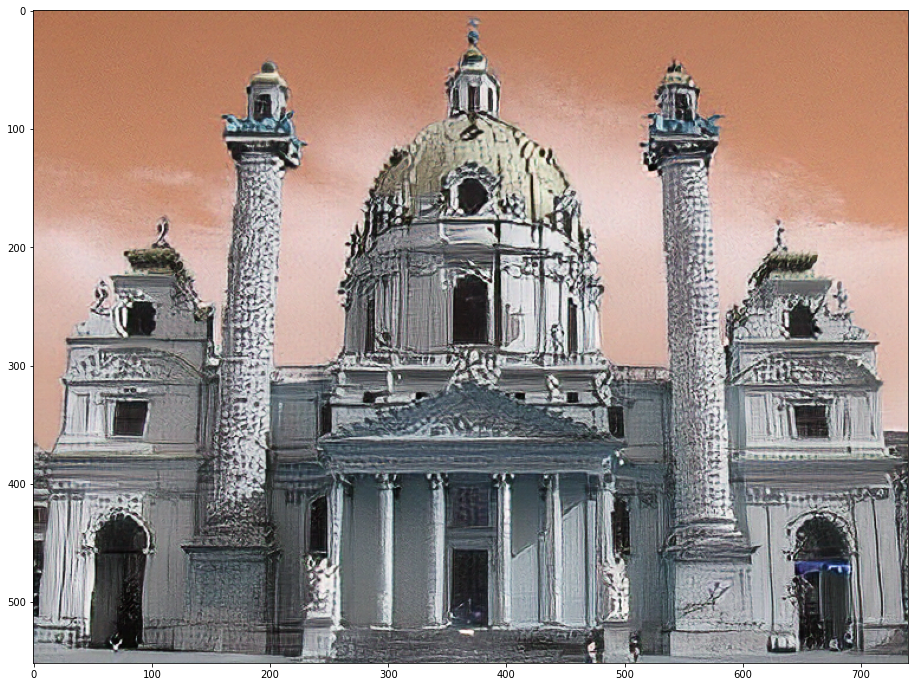

In [6]:
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

# 원본 이미지를 1/4로 줄인다.
quarter_img = cv2.resize(hr_img, dsize=(hr_shape[1]//4, hr_shape[0]//4))
# 원본 이미지를 SRGAN을 이용하여 원본이미지의 사이즈로 resize한다.
srgan_img = apply_srgan(quarter_img)
plt.figure(figsize=(20,12))
plt.imshow(srgan_img)
srgan_img.shape[:2]

/usr/local/lib/python3.7/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


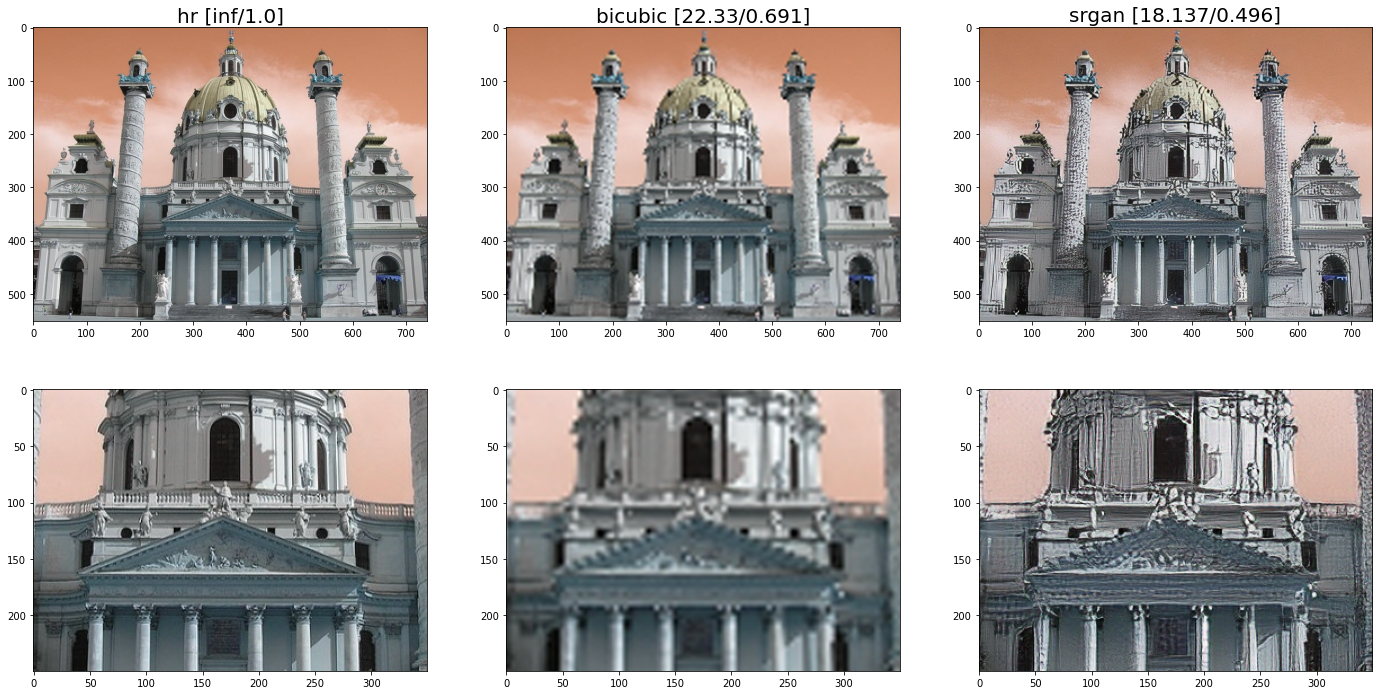

In [7]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

images = [hr_img, bicubic_img, srgan_img]
titles = ["hr", "bicubic", "srgan"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(hr_img, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(hr_img, i, multichannel=True), 3) for i in images]

plt.figure(figsize=(24,12))
for i in range(len(images)):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)

left_top = (200,200)

for i in range(len(images)):
    plt.subplot(2,3,3+i+1)
    plt.imshow(crop(images[i], left_top, 250, 350))

### 왜 이런 결과가 나왔을까?

전체 이미지로 봐도 어느 정도 구별이 가능하지만 crop한 이미지로 보면 확실한 구분이 된다.    
육안으로 봤을 때는 SRGAN 모델을 이용한 고해상도 이미지가 Bicubic interpolation 을 이용한 고해상도 이미지보다 더욱 품질이 좋은 이미지 처럼 보이지만, PSNR 결과와 SSIM 결과를 보면 오히려 SRGAN 모델을 이용한 고해상도 이미지가 더 떨어진다.   
그 이유는 노드에서도 설명하였지만 SRGAN으로 만든 고해상도 이미지가 Bicubic interpolation 으로 만든 고해상도 이미지보다 선명하게 이상한 이미지를 만들기 때문이다. 이는 SRGAN 모델에서 Generator(생성자)가 고해상도 이미지를 생성하는 과정 중에 Dicriminator(판별자)를 속이기 위해 이미지를 진짜 같이 선명하게 만들도록 학습하기 때문이다.



## 프로젝트 1-2

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(720, 539)


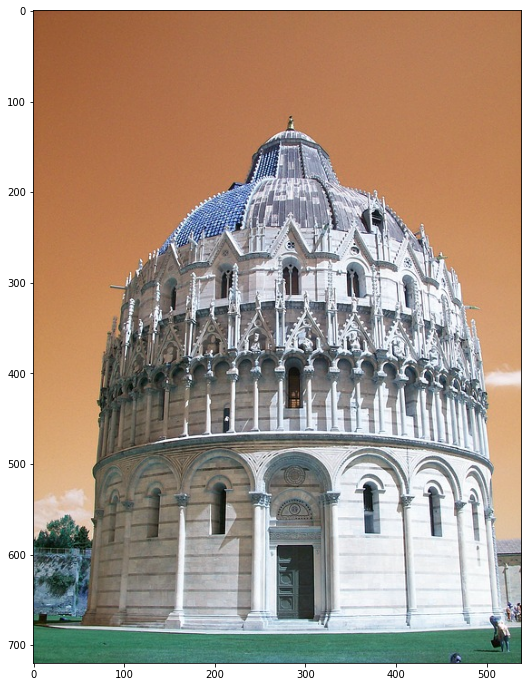

In [8]:
import cv2
import matplotlib.pyplot as plt

lr_img = cv2.imread('/content/drive/MyDrive/EX/EX16/lr_baroque.jpg') # skimage에서 제공하는 예제 이미지를 불러온다.
#hr_img = cv2.resize(hr_img, dsize=(hr_img.shape[1], hr_img.shape[0]+1))
lr_shape = lr_img.shape[:2]

print(lr_shape) # 이미지의 크기를 출력한다.

plt.figure(figsize=(20,12))
plt.imshow(lr_img)

In [9]:
srgan_lr_img = apply_srgan(lr_img)
bicubic_lr_img = cv2.resize(lr_img,dsize=(lr_shape[1]*4, lr_shape[0]*4),interpolation=cv2.INTER_CUBIC)

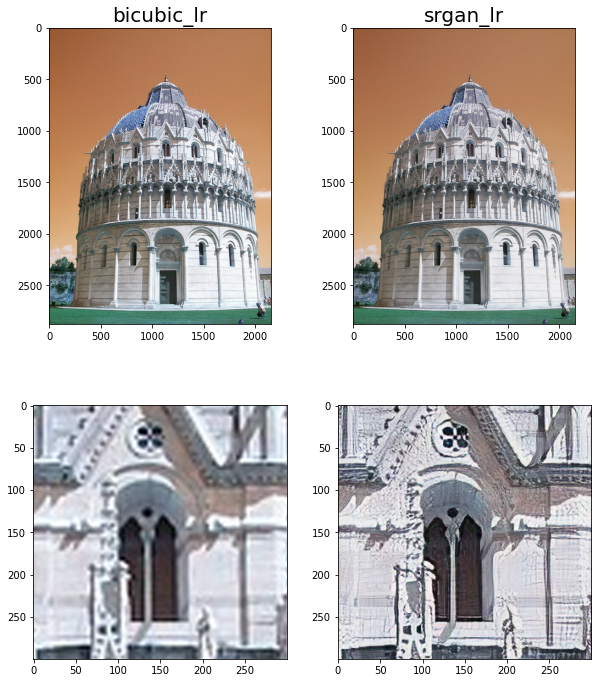

In [10]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

images_lr = [bicubic_lr_img, srgan_lr_img]
titles_lr = ["bicubic_lr", "srgan_lr"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
#psnr_lr = [round(peak_signal_noise_ratio(lr_img, i), 3) for i in images_lr]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
#ssim_lr = [round(structural_similarity(lr_img, i, multichannel=True), 3) for i in images_lr]

plt.figure(figsize=(10,12))
for i in range(len(images_lr)):
    plt.subplot(2,2,i+1)
    plt.imshow(images_lr[i])
    #plt.title(titles_lr[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)
    plt.title(titles_lr[i], fontsize=20)

left_top_lr = (1000,1000)

for i in range(len(images_lr)):
    plt.subplot(2,2,2+i+1)
    plt.imshow(crop(images_lr[i], left_top_lr, 300, 300))

### 왜 이런 결과가 나왔을까?

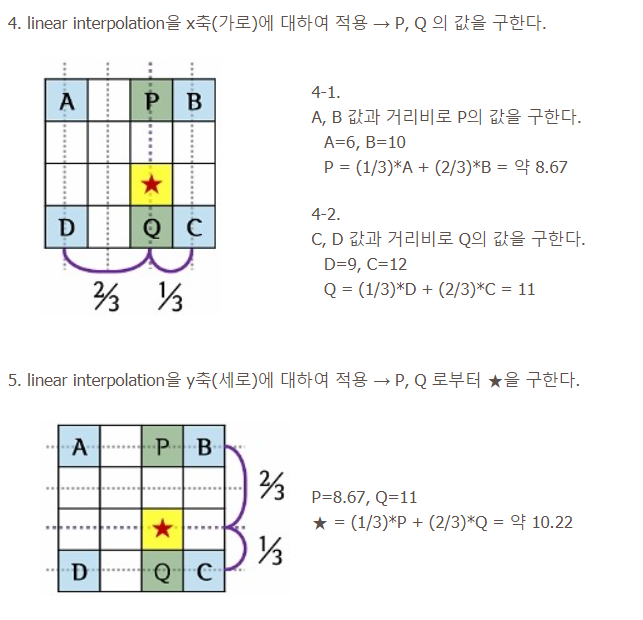

[출처 : 정아님의 네이버 블로그](https://blog.naver.com/dic1224/220882679460)

원본 이미지(lr_img)와 SRGAN 및 Bicubic interpolation의 이미지 사이즈가 다르기 때문에 프로젝트 1-1 처럼 PSNR과 SSIM의 결과를 비교할 수는 없지만 육안으로 어느정도 결과를 검토할 수 있다.   
위의 Bicubic interpolation은 위 그림처럼 주변 픽셀간의 거리를 통해 비어있는 좌표의 픽셀 값을 구하는 것이기 때문에 이미지의 사이즈를 늘렸을 때 0값으로 채워지지는 않지만, 선명하지 않게 된다.
하지만 SRGAN 모델 같은 경우는 Generator 가 Discriminator를 속이기 위해 학습과정에서 지속적으로 이미지를 재생성하므로 학습이 진행될수록 이미지가 선명해지지만 원본과 비교하였을 때 특정 픽셀의 값이 다를 수 있다.

# 프로젝트 2 : SRGAN을 이용해 고해상도 gif생성하기
---

이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행해보자.

In [11]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("/content/drive/MyDrive/EX/EX16/fire_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))
print(frames[0].shape[0])

frame 수 : 14
frame 크기 : (282, 300, 3)
282


In [12]:
frame_sr_srgan = []
frame_sr_bicubic = []

for i in range(len(frames)):
    frame_sr_srgan.append(apply_srgan(frames[i]))
    frame_sr_bicubic.append(cv2.resize(frames[i],dsize=(frames[i].shape[1]*4, frames[i].shape[0]*4),interpolation=cv2.INTER_CUBIC))

print("뿅=3")

뿅=3


In [13]:
import imageio

imageio.mimsave("/content/drive/MyDrive/EX/EX16/fire_hr_srgan.gif", frame_sr_srgan)
imageio.mimsave("/content/drive/MyDrive/EX/EX16/frame_sr_bicubic.gif", frame_sr_bicubic)

In [14]:
from IPython.display import Image as show_gif
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

show_gif(open("/content/drive/MyDrive/EX/EX16/fire_hr_srgan.gif",'rb').read(), width=800) # width 는 적당히 큰 값으로 설정해주세요

Output hidden; open in https://colab.research.google.com to view.

In [15]:
show_gif(open("/content/drive/MyDrive/EX/EX16/frame_sr_bicubic.gif",'rb').read(), width=800) # width 는 적당히 큰 값으로 설정해주세요

Output hidden; open in https://colab.research.google.com to view.

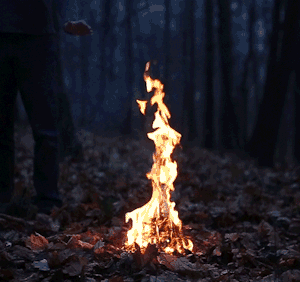

In [16]:
show_gif(open("/content/drive/MyDrive/EX/EX16/fire_lr.gif",'rb').read(), width=800) # width 는 적당히 큰 값으로 설정해주세요

<img src="fire_hr_srgan.gif" width="800px" height="1000px"></img>

<center>fire_hr_srgan.gif : SRGAN 모델을 이용한 고해상도 gif</center>  

<img src="frame_sr_bicubic.gif" width="800px" height="1000px"></img>

<center>frame_sr_bicubic.gif : bicubic interpolation을 이용한 고해상도 gif</center>

<img src="fire_lr.gif" width="800px" height="1000px"></img>

<center>fire_lr.gif : 기존 노드에서 제시한 gif (저해상도 gif)</center>

# 회고
---

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

이번 프로젝트에서 어려웠던 점은 역시나 Super resolution 기술에 대한 개념 이해가 가장 어려웠고, 그 후에는 노드대로 진행 시 gif를 노트북에 표현은 잘되지만 해당 노트북을 github에 올리면 gif가 안보이는 현상(
Output hidden; open in https://colab.research.google.com to view.라고 출력...)이 발생되어 이 현상을 수정하는데 오래 걸렸다.    
프로젝트를 진행하면서 Bicubic 과 SRGAN 을 이용하여 고해상도 이미지를 출력 하는 과정을 이해할 수 있었고 차이점을 알 수 있었다. 그런데 분명 육안으로는 SRGAN이 좀 더 선명하고 품질이 높은 이미지라고 판단이 되지만 PSNR 결과와 SSIM 값으로 봤을 때는 오히려 SRGAN이 더 떨어진다... 그러면 육안이 아닌 정량적으로 측정하고 싶을때는 어떻게 해야되나...를 모르겠다ㅠㅠㅠ    

또한 gif도 프레임별로 쪼개서 이미지 프로세싱할 수 있는 함수를 제공해주는 부분이 신기하였다.